In [70]:
from pyspark.sql.functions import to_date

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Iowa2025").config("spark.memory.offHeap.enabled", "true").config(
    "spark.memory.offHeap.size", "10g").config('spark.sql.catalogImplementation', 'hive').config('spark.sql.legacy.createHiveTableByDefault', 'false').getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

In [71]:
crashes = spark.read.csv("data/Crashes_in_Iowa_by_Severity_and_Day_20250220.csv", header=True, inferSchema=True)

crashes = crashes.withColumn("Date of Crash", to_date(crashes["Date of Crash"], "MM/dd/yyyy"))


In [72]:
crashes.show(5)
crashes.createOrReplaceTempView("crashes")
spark.sql("SELECT * FROM crashes LIMIT 5").show()

+-------------+--------------------+-------+
|Date of Crash|      Crash Severity|Crashes|
+-------------+--------------------+-------+
|   2014-01-01|    Possible/Unknown|     22|
|   2014-01-01|        Minor Injury|     11|
|   2014-01-01|Property Damage Only|    186|
|   2014-01-01|        Major Injury|      6|
|   2014-01-02|Property Damage Only|    142|
+-------------+--------------------+-------+
only showing top 5 rows

+-------------+--------------------+-------+
|Date of Crash|      Crash Severity|Crashes|
+-------------+--------------------+-------+
|   2014-01-01|    Possible/Unknown|     22|
|   2014-01-01|        Minor Injury|     11|
|   2014-01-01|Property Damage Only|    186|
|   2014-01-01|        Major Injury|      6|
|   2014-01-02|Property Damage Only|    142|
+-------------+--------------------+-------+


In [73]:
liquorSales = spark.read.csv("./data/Iowa_Liquor_Sales_sample.csv", header=True, inferSchema=True)

liquorSales = liquorSales.withColumn("Date", to_date(liquorSales["Date"], "MM/dd/yyyy"))

liquorSales.createOrReplaceTempView("liquorSales")

In [74]:
liquorSales.show(5)

+-------------------+----------+------------+--------------------+--------------------+-------------+--------+--------------------+-------------+---------+--------+--------------------+-------------+--------------------+-----------+--------------------+----+------------------+-----------------+-------------------+------------+--------------+--------------------+---------------------+
|Invoice/Item Number|      Date|Store Number|          Store Name|             Address|         City|Zip Code|      Store Location|County Number|   County|Category|       Category Name|Vendor Number|         Vendor Name|Item Number|    Item Description|Pack|Bottle Volume (ml)|State Bottle Cost|State Bottle Retail|Bottles Sold|Sale (Dollars)|Volume Sold (Liters)|Volume Sold (Gallons)|
+-------------------+----------+------------+--------------------+--------------------+-------------+--------+--------------------+-------------+---------+--------+--------------------+-------------+--------------------+------

In [84]:
liquorAndCrashes = spark.sql("SELECT ROUND(SUM(`Volume Sold (liters)`)) AS liquorSold, SUM(c.Crashes) as Crashes, date_format(l.`Date`, 'yyyyMM') AS monthOfYear FROM liquorSales l, crashes c WHERE date_format(l.`Date`, 'yyyyMM') = date_format(c.`Date of Crash`, 'yyyyMM') AND date_format(l.`Date`, 'yyyy') BETWEEN '2014' AND '2016' GROUP BY date_format(l.`Date`, 'yyyyMM')  ORDER BY date_format(l.`Date`, 'yyyyMM')")


In [85]:
liquorAndCrashes.show()

+----------+-------+-----------+
|liquorSold|Crashes|monthOfYear|
+----------+-------+-----------+
|  222340.0| 831810|     201401|
|  144190.0| 836528|     201402|
|  162964.0| 643986|     201403|
|  186178.0| 541336|     201404|
|  185184.0| 582860|     201405|
|  236250.0| 828738|     201406|
|  229508.0| 789392|     201407|
|  171569.0| 624676|     201408|
|  239364.0| 711744|     201409|
|  230142.0| 751680|     201410|
|  160180.0| 988696|     201411|
|  234457.0|1028817|     201412|
|  122961.0| 795468|     201501|
|  172127.0| 690300|     201502|
|  156422.0| 625430|     201503|
|  193815.0| 647680|     201504|
|  195261.0| 796168|     201505|
|  237702.0| 949584|     201506|
|  201819.0| 727207|     201507|
|  211978.0| 706266|     201508|
+----------+-------+-----------+


In [86]:
import matplotlib.pyplot as plt
liquorAndCrashesData = liquorAndCrashes.toPandas()

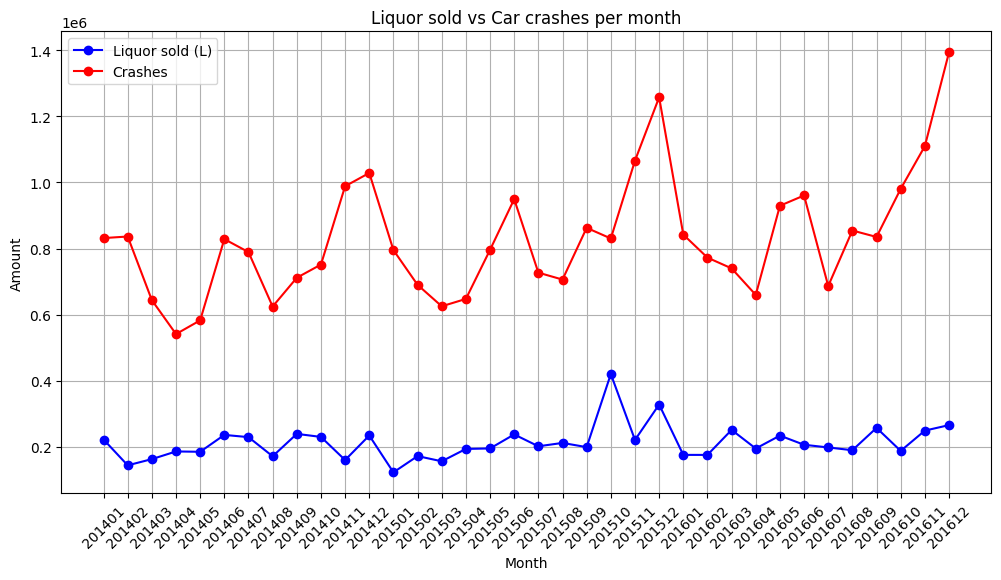

In [87]:
plt.figure(figsize=(12, 6))
plt.plot(liquorAndCrashesData['monthOfYear'], liquorAndCrashesData['liquorSold'], marker='o', linestyle='-', color='b', label='Liquor sold (L)')
plt.plot(liquorAndCrashesData['monthOfYear'], liquorAndCrashesData['Crashes'], marker='o', linestyle='-', color='r', label='Crashes')
plt.title('Liquor sold vs Car crashes per month')
plt.xlabel('Month')
plt.ylabel('Amount')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()